In [88]:
using HDF5, EzXML, Glob, Dates, Plots, JuMP, StatsBase, Symbolics, DataFrames, CSV, Random, Distributions, Printf, LinearAlgebra, StatsPlots, KernelDensity, GLM
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
include("/Users/jjc/CSF/CSF Dynamics Scripts/BayesianCSFtools.jl")

# Load files
datapath = "/Users/jjc/CSF/Recordings/"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath)
filenames_trunc = Vector{String}()
for i = eachindex(files)
    push!(filenames_trunc, files[i][length(datapath)+1:end-5])
end

# Initialise dataframe
df = DataFrame(filename=filenames_trunc, R2_icp_amp=NaN,
    Rcsf_icm=NaN, E_icm=NaN, Ib_icm=NaN, P0_icm=NaN,
    Rcsf_mode=NaN, E_mode=NaN, Ib_mode=NaN, P0_mode=NaN,
    Rcsf_mean=NaN, E_mean=NaN, Ib_mean=NaN, P0_mean=NaN,
    Rcsf_median=NaN, E_median=NaN, Ib_median=NaN, P0_median=NaN,
    Rcsf_ml=NaN, E_ml=NaN, Ib_ml=NaN, P0_ml=NaN,
    Rcsf_std=NaN, E_std=NaN, P0_std=NaN, Ib_std=NaN,
    Rcsf_prior_mean=NaN, E_prior_mean=NaN, P0_prior_mean=NaN,
    Rcsf_prior_std=NaN, E_prior_std=NaN, P0_prior_std=NaN,
    RMSE_mode=NaN, RMSE_median=NaN, RMSE_mean=NaN, RMSE_ml=NaN, RMSE_icm=NaN,
    R2_mode=NaN, R2_median=NaN, R2_mean=NaN, R2_ml=NaN, R2_icm=NaN,
    Pss=NaN, P_b=NaN, I_inf=NaN, P_p=NaN, inf_length=NaN, one_needle=NaN, Rn=NaN, rec_dur_s=NaN,
    inf_st=NaN, inf_en=NaN, plat_st=NaN, plat_en=NaN, over_forty=NaN, above_Pss=NaN)

# Settings
# 1.0 = only curve fitting, 0.0 = only PV curve fitting
alpha = 1.0
num_iter = 10^5
# method = "standard"
# method = "Pss"
method = "2"
means = [10.0, 0.37, 11.1] # Based on literature
stddevs = [4.95, 0.13, 2.97]

# Main loop
fid = 1
# for fid = 1141

chain, chisave, Ib_chain, P0_static, R2_P0 = main(files[fid], num_iter, "informative", alpha, method, means, stddevs)
params_modes, params_medians, params_means, params_stddevs = mean_and_stddev(chain)

# This will be the set of parameters with maximum likelihood 
opt_min = findmin(chisave)[2]
params_ml = chain[opt_min, :]

function get_rmse(Rcsf, E, P_0, Pss, method)
    if method == "standard"
        I_b = (Data["P_b"] - P_0) / Rcsf
        rmse = calc_model_plot(I_b, E, P_0)[2]
    elseif method == "Pss"
        I_b = (Data["P_b"] - Pss) / Rcsf
        rmse = calc_model_plot(I_b, E, P_0, Pss)[2]
    elseif method == "2"
        I_b = (Data["P_b"] - Data["P0_static"]) / Rcsf
        rmse = calc_model_plot(I_b, E, Data["P0_static"])[2]
    else
        I_b = (Data["P_b"] - Pss) / Rcsf
        rmse = calc_model_plot(I_b, E, P_0, Pss)[2]
    end
    return rmse
end

df.P_b[fid] = Data["P_b"]
df.P_p[fid] = Data["P_p"]
df.inf_length[fid] = (Data["infusion_end_frame"] - Data["infusion_start_frame"]) # in frames
df.Rcsf_icm[fid] = Data["Rcsf"]
df.E_icm[fid] = Data["E"]
df.Ib_icm[fid] = Data["I_b"]
df.P0_icm[fid] = Data["P_0"]
df.I_inf[fid] = Data["I_inf"]
df.one_needle[fid] = Data["one_needle"]
df.Rn[fid] = Data["Rn"]
df.rec_dur_s[fid] = Data["rec_dur_s"]
df.inf_st[fid] = Data["infusion_start_frame"]
df.inf_en[fid] = Data["infusion_end_frame"]
df.plat_st[fid] = Data["plateau_start"]
df.plat_en[fid] = Data["plateau_end"]
df.over_forty[fid] = sum(Data["ICP"].>40)

if method == "2"
    df.Rcsf_prior_mean[fid], df.E_prior_mean[fid] = means
    df.Rcsf_prior_std[fid], df.E_prior_std[fid] = stddevs
    df.Rcsf_mode[fid], df.E_mode[fid], df.P0_mode[fid] = vcat(params_modes, Data["P0_static"])
    df.Rcsf_median[fid], df.E_median[fid], df.P0_median[fid] = hcat(params_medians, Data["P0_static"])
    df.Rcsf_mean[fid], df.E_mean[fid], df.P0_mean[fid] = hcat(params_means, Data["P0_static"])
    df.Rcsf_ml[fid], df.E_ml[fid], df.P0_ml[fid] = vcat(params_ml, Data["P0_static"])
    df.Rcsf_std[fid], df.E_std[fid] = params_stddevs
else
    df.Rcsf_prior_mean[fid], df.E_prior_mean[fid], df.P0_prior_mean[fid] = means
    df.Rcsf_prior_std[fid], df.E_prior_std[fid], df.P0_prior_std[fid] = stddevs
    df.Rcsf_mode[fid], df.E_mode[fid], df.P0_mode[fid] = params_modes
    df.Rcsf_median[fid], df.E_median[fid], df.P0_median[fid] = params_medians
    df.Rcsf_mean[fid], df.E_mean[fid], df.P0_mean[fid] = params_means
    df.Rcsf_ml[fid], df.E_ml[fid], df.P0_ml[fid] = params_ml
    df.Rcsf_std[fid], df.E_std[fid], df.P0_std[fid] = params_stddevs
end

df.Ib_mean[fid] = mean(Ib_chain)
df.Ib_mode[fid] = StatsBase.mode(Ib_chain)
df.Ib_median[fid] = median(Ib_chain)
df.Ib_std[fid] = std(Ib_chain)
df.Ib_ml[fid] = Ib_chain[opt_min]

if method == "standard"
    df.RMSE_mode[fid] = get_rmse(params_modes..., params_modes[3], method)
    df.RMSE_median[fid] = get_rmse(params_medians..., params_medians[3], method)
    df.RMSE_mean[fid] = get_rmse(params_means..., params_means[3], method)
    df.RMSE_ml[fid] = get_rmse(params_ml..., params_ml[3], method)
    df.R2_mode[fid] = press_vol_curve(params_modes[1], params_modes[3], icp_inf)[4]
    df.R2_median[fid] = press_vol_curve(params_medians[1], params_medians[3], icp_inf)[4]
    df.R2_mean[fid] = press_vol_curve(params_means[1], params_means[3], icp_inf)[4]
    df.R2_ml[fid] = press_vol_curve(params_ml[1], params_ml[3], icp_inf)[4]
    df.above_Pss[fid] = sum(Data["ICP"].>P_0)
    df.above_Pss[fid] = sum(Data["ICP"].>params_means[3])/length(Data["ICP"])
elseif method == "Pss"
    df.RMSE_mode[fid] = get_rmse(params_modes[1:2]..., Data["P_0"], params_modes[3], method)
    df.RMSE_median[fid] = get_rmse(params_modes[1:2]..., Data["P_0"], params_medians[3], method)
    df.RMSE_mean[fid] = get_rmse(params_modes[1:2]..., Data["P_0"], params_means[3], method)
    df.RMSE_ml[fid] = get_rmse(params_ml[1:2]..., Data["P_0"], params_ml[3], method)
    df.R2_mode[fid] = press_vol_curve(params_modes[1], params_modes[3], icp_inf)[4]
    df.R2_median[fid] = press_vol_curve(params_medians[1], params_medians[3], icp_inf)[4]
    df.R2_mean[fid] = press_vol_curve(params_means[1], params_means[3], icp_inf)[4]
    df.R2_ml[fid] = press_vol_curve(params_ml[1], params_ml[3], icp_inf)[4]
    df.above_Pss[fid] = sum(Data["ICP"].>params_means[3])/length(Data["ICP"])
elseif method == "2"
    df.RMSE_mode[fid] = get_rmse(params_modes[1:2]..., Data["P0_static"], Data["P0_static"], method)
    df.RMSE_median[fid] = get_rmse(params_modes[1:2]..., Data["P0_static"], Data["P0_static"], method)
    df.RMSE_mean[fid] = get_rmse(params_modes[1:2]..., Data["P0_static"], Data["P0_static"], method)
    df.RMSE_ml[fid] = get_rmse(params_ml[1:2]..., Data["P0_static"], Data["P0_static"], method)
    df.R2_mode[fid] = press_vol_curve(params_modes[1], Data["P0_static"], icp_inf)[4]
    df.R2_median[fid] = press_vol_curve(params_medians[1], Data["P0_static"], icp_inf)[4]
    df.R2_mean[fid] = press_vol_curve(params_means[1], Data["P0_static"], icp_inf)[4]
    df.R2_ml[fid] = press_vol_curve(params_ml[1], Data["P0_static"], icp_inf)[4]
    df.above_Pss[fid] = sum(Data["ICP"].>Data["P0_static"])/length(Data["ICP"])
else
    df.RMSE_mode[fid] = get_rmse(params_modes..., method)
    df.RMSE_median[fid] = get_rmse(params_medians..., method)
    df.RMSE_mean[fid] = get_rmse(params_means..., method)
    df.RMSE_ml[fid] = get_rmse(params_ml..., method)
    df.R2_mode[fid] = press_vol_curve(params_modes[1], params_modes[4], icp_inf)[4]
    df.R2_median[fid] = press_vol_curve(params_medians[1], params_medians[4], icp_inf)[4]
    df.R2_mean[fid] = press_vol_curve(params_means[1], params_means[4], icp_inf)[4]
    df.R2_ml[fid] = press_vol_curve(params_ml[1], params_ml[4], icp_inf)[4]
    df.above_Pss[fid] = sum(Data["ICP"].>params_means[4])/length(Data["ICP"])
end

df.R2_icm[fid] = press_vol_curve(Data["Rcsf"], Data["P_0"], icp_inf)[4]
df.RMSE_icm[fid] = get_rmse(Data["Rcsf"], Data["E"], Data["P_0"], Data["P_0"], "standard")

icp = Data["ICP"][2:end]
amp = Data["AMP"][2:end]
rm = .~isnan.(amp) .&& amp .> 0.0
amp = amp[rm]
icp = icp[rm]
reg = GLM.lm(GLM.@formula(y ~ x), DataFrame(x=icp, y=amp))
df.R2_icp_amp[fid] = r2(reg)

# end

# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)
CSV.write("/Users/jjc/CSF/results_feb2023/Results_2params.csv", df)



"/Users/jjc/CSF/results_feb2023/Results_2params.csv"

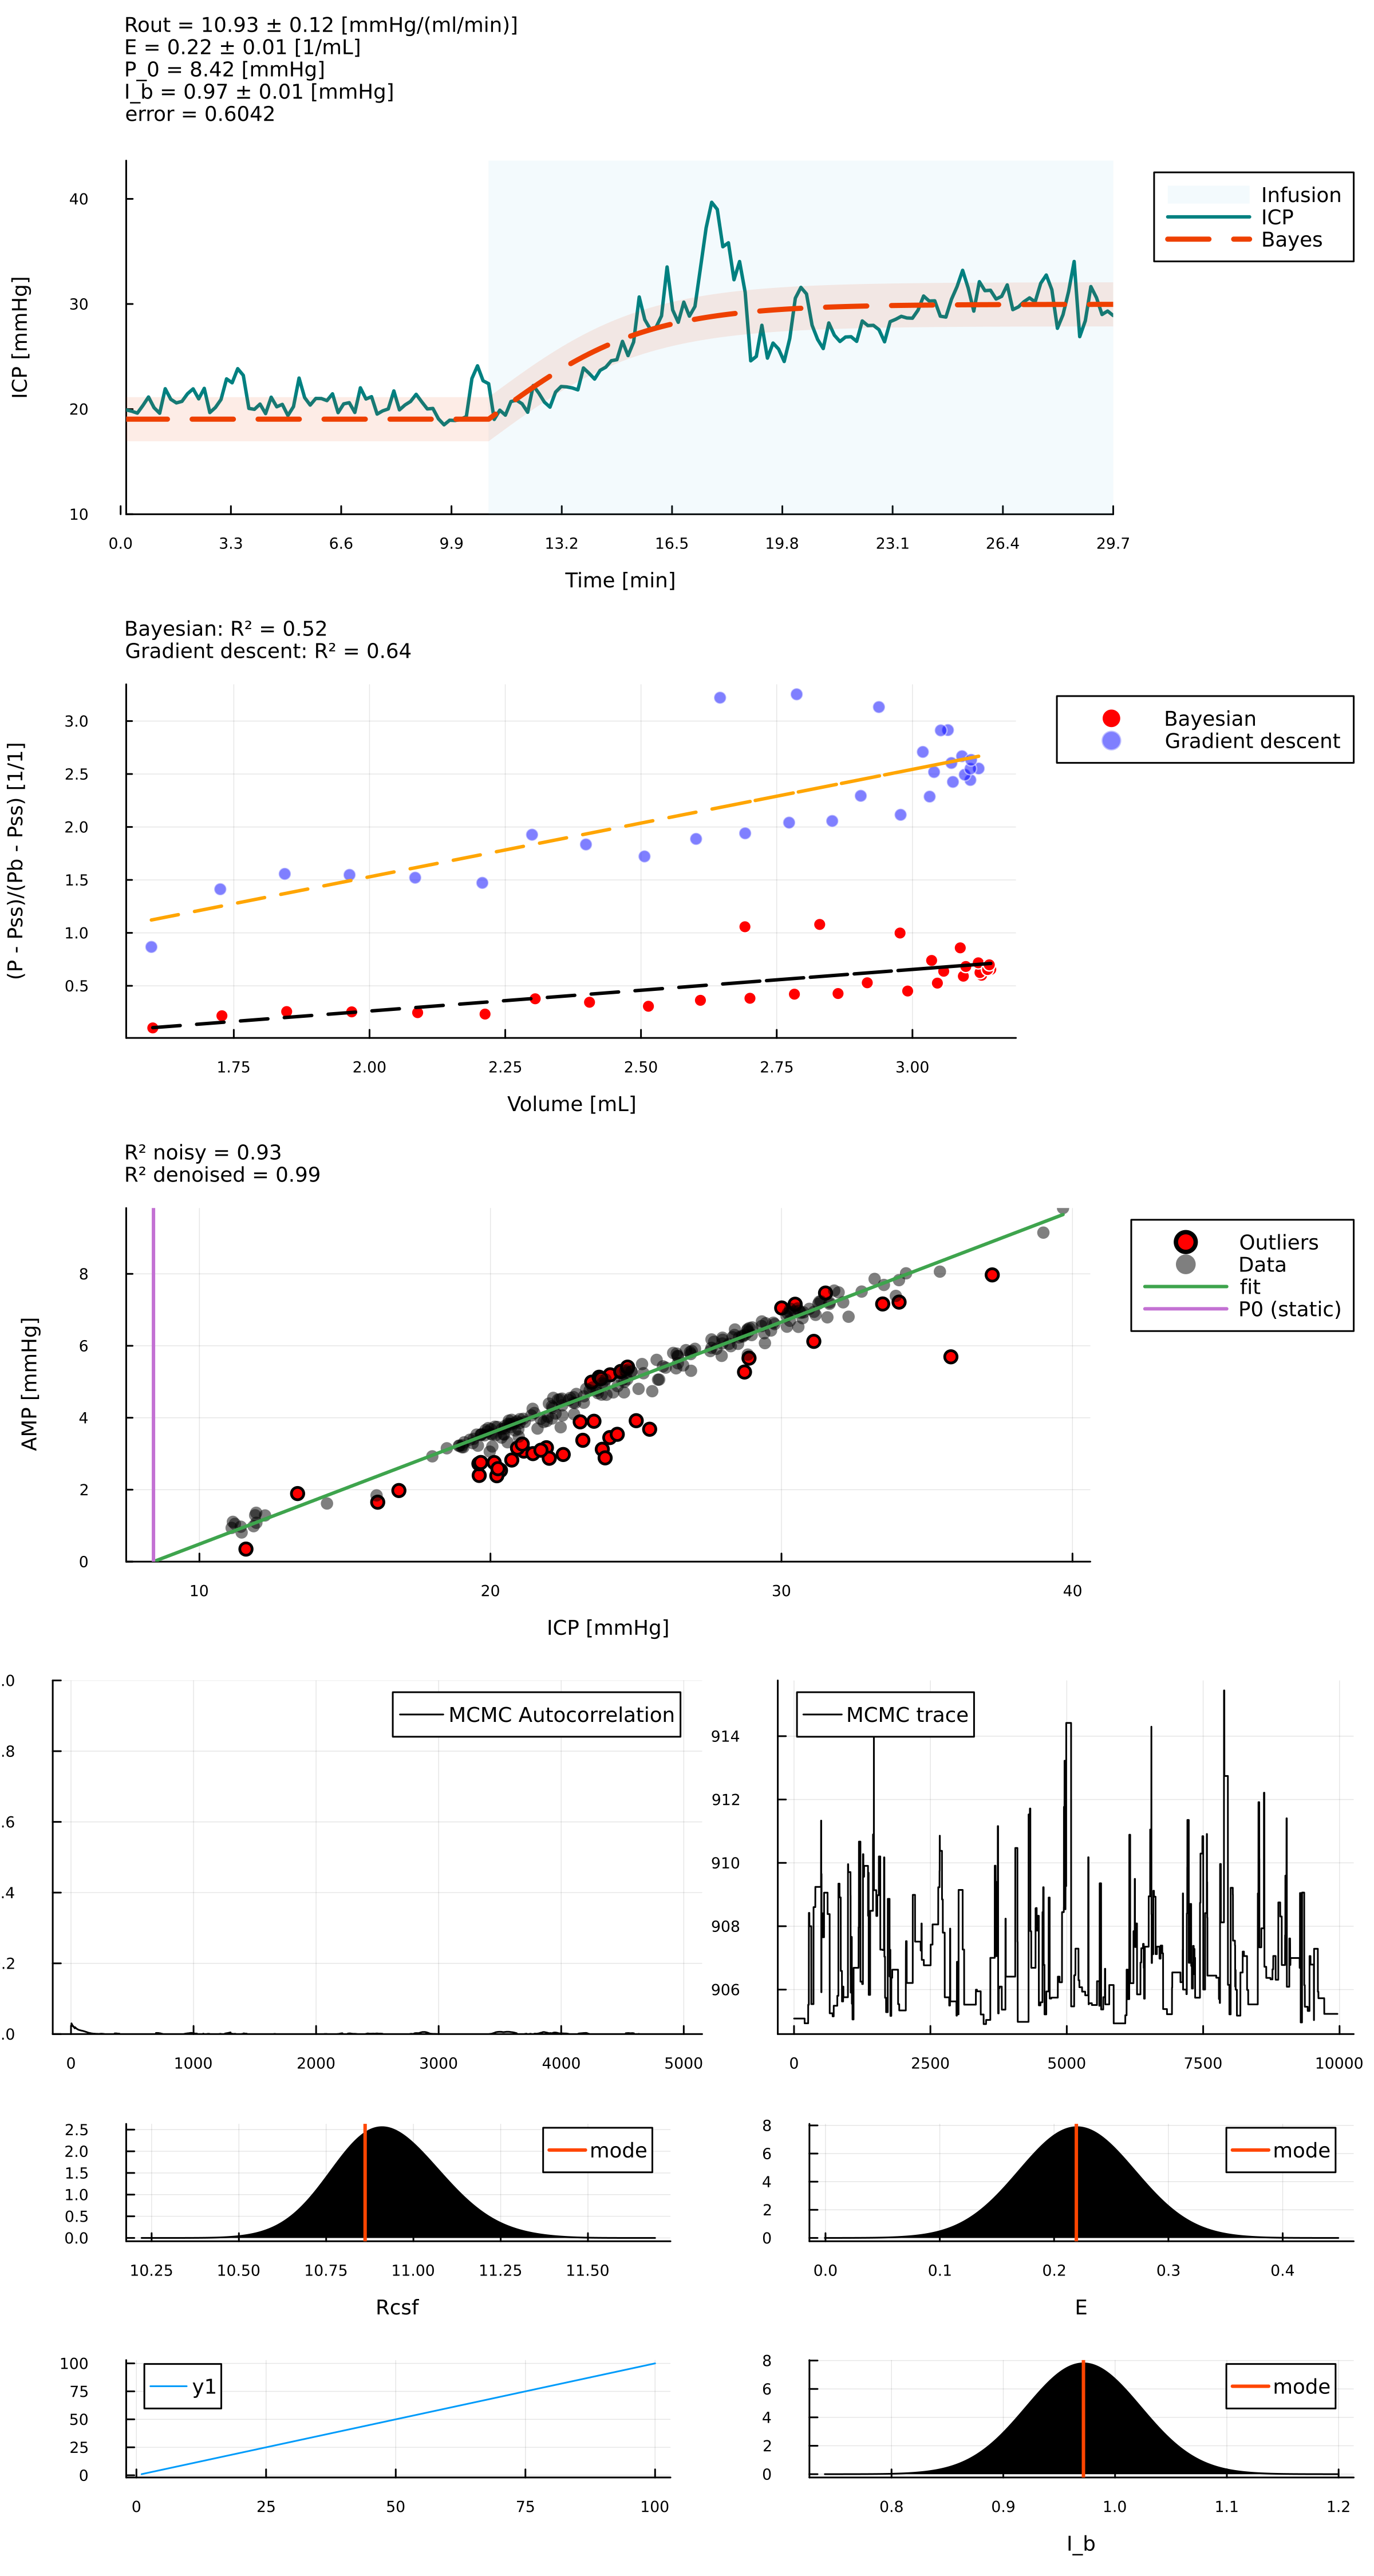

In [89]:
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
include("/Users/jjc/CSF/CSF Dynamics Scripts/BayesianCSFtools.jl")

bayescol = :red
icmcol = :blue
bgcolor = :white

if method == "standard"
        Rcsf, E, P_0 = params_means
        Pss = P_0
        I_b = (Data["P_b"] - P_0) / Rcsf
        rmse = get_rmse(Rcsf, E, P_0, P_0, method)
        titlestring = (@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", Rcsf, params_stddevs[1]) *
                       @sprintf("E = %0.2f ± %0.2f [1/mL]\n", E, params_stddevs[2]) *
                       @sprintf("P_0 = %0.2f ± %0.2f [mmHg]\n", P_0, params_stddevs[3]) *
                       @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
                       @sprintf("error = %0.4f \n", rmse))
elseif method == "Pss"
        Rcsf, E, Pss = params_means
        P_0 = Data["P0_static"]
        I_b = (Data["P_b"] - Pss) / Rcsf
        rmse = get_rmse(Rcsf, E, P_0, Pss, method)
        titlestring = (@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", Rcsf, params_stddevs[1]) *
                       @sprintf("E = %0.2f ± %0.2f [1/mL]\n", E, params_stddevs[2]) *
                       @sprintf("Pss = %0.2f ± %0.2f [mmHg]\n", Pss, params_stddevs[3]) *
                       @sprintf("P_0 = %0.2f [mmHg]\n", P_0) *
                       @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
                       @sprintf("error = %0.4f \n", rmse))
elseif method == "4"
        Rcsf, E, P_0, Pss = params_means
        I_b = (Data["P_b"] - Pss) / Rcsf
        rmse = get_rmse(Rcsf, E, P_0, Pss, method)
        titlestring = (@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", Rcsf, params_stddevs[1]) *
                       @sprintf("E = %0.2f ± %0.2f [1/mL]\n", E, params_stddevs[2]) *
                       @sprintf("Pss = %0.2f ± %0.2f [mmHg]\n", Pss, params_stddevs[4]) *
                       @sprintf("P_0 = %0.2f ± %0.2f [mmHg]\n", P_0, params_stddevs[3]) *
                       @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
                       @sprintf("error = %0.4f \n", rmse))
elseif method == "2"
        Rcsf, E = params_means
        P_0 = Data["P0_static"]
        Pss = P_0
        I_b = (Data["P_b"] - P_0) / Rcsf
        rmse = get_rmse(Rcsf, E, P_0, P_0, method)
        titlestring = (@sprintf("Rout = %0.2f ± %0.2f [mmHg/(ml/min)]\n", Rcsf, params_stddevs[1]) *
                       @sprintf("E = %0.2f ± %0.2f [1/mL]\n", E, params_stddevs[2]) *
                       @sprintf("P_0 = %0.2f [mmHg]\n", P_0) *
                       @sprintf("I_b = %0.2f ± %0.2f [mmHg]\n", I_b, std(Ib_chain)) *
                       @sprintf("error = %0.4f \n", rmse))
end

h1 = plotmodel(I_b, E, P_0, Pss, params_means, params_stddevs, "dar", "")
title!(titlestring, titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]", yguidefontsize=8, xguidefontsize=8)

volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, Pss, icp_inf)
h2 = plot(volRes, log.(pressRes), seriestype=:scatter, makersize=5, color=bayescol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1, label="Bayesian", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", yguidefontsize=8, xguidefontsize=8)
plot!(volRes, fitted_curve, lw=2, linecolor=:black, linestyle=:dash, legend=:outertopright, label="")

volRes, pressRes, fitted_curve, R2_icm, MSE = press_vol_curve(Data["Rcsf"], Data["P_0"], icp_inf)
plot!(volRes, log.(pressRes), seriestype=:scatter, alpha=0.5, makersize=5, color=icmcol, markerstrokewidth=0.5, markerstrokecolor=bgcolor, linewidth=1,
        label="Gradient descent", grid=true, titlefontsize=8, titlealign=:left, background=bgcolor, xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", yguidefontsize=8, xguidefontsize=8)
plot!(volRes, fitted_curve, lw=2, linecolor=:orange, linestyle=:dash, legend=:outertopright, label="")
title!(@sprintf("Bayesian: R² = %0.2f\nGradient descent: R² = %0.2f", R2, R2_icm), titlealign=:left, titlefontsize=8)

bw = 0.05

kernd = kde(chain[:, 1], bandwidth=bw * 2)
h3 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="", yguidefontsize=8, xguidefontsize=8)
vline!(h3, [params_modes[1]], lw=2, label="mode", linecolor=:orangered, xlabel="Rcsf", ylabel="\n\n")

kernd = kde(chain[:, 2], bandwidth=bw)
h4 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="", yguidefontsize=8, xguidefontsize=8)
vline!(h4, [params_modes[2]], lw=2, label="mode", linecolor=:orangered, xlabel="E", ylabel="\n\n")

if size(chain)[2] == 2
        h5 = plot(1:100)
else
        kernd = kde(chain[:, 3], bandwidth=bw * 5)
        h5 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="", yguidefontsize=8, xguidefontsize=8)
        vline!(h5, [params_modes[3]], lw=2, label="mode", linecolor=:orangered, xlabel="P_0", ylabel="\n\n")
        vline!(h5, [Data["P_0"]], lw=2, label="static", linecolor=:teal)
end

kernd = kde(Ib_chain, bandwidth=bw)
h6 = plot(kernd, fillrange=zeros(length(kernd.density)), fillalpha=1, c="black", label="", yguidefontsize=8, xguidefontsize=8)
smooth_dist = kde(Ib_chain, bandwidth=0.05) # Mode is unstable if there are very small differences between values - smoothen
smooth_dist_vals = collect(smooth_dist.x)
Ib_mode = smooth_dist_vals[findmax(kernd.density)[2]]
vline!(h6, [Ib_mode], lw=2, label="mode", linecolor=:orangered, xlabel="I_b", ylabel="\n\n")


# Plot AMP-ICP plot
icp = Data["ICP"][2:end]
amp = Data["AMP"][2:end]
rm = .~isnan.(amp)
rm = rm .&& amp .> 0.1
amp = amp[rm]
icp = icp[rm]
x = icp
y = amp
reg = lm(@formula(y ~ x), DataFrame(x=icp, y=amp))
R2_old = r2(reg)
residuals = y .- GLM.predict(reg, DataFrame(x=icp, y=amp))
std_res = residuals ./ std(residuals)
keep = abs.(std_res) .<= 1
reg_cleaned = lm(@formula(y ~ x), DataFrame(x=icp[keep], y=amp[keep]))
c, a = GLM.coeftable(reg_cleaned).cols[1, 1]
R2 = r2(reg_cleaned)
y_intercept = -c / a
x_values = range(y_intercept, maximum(icp), length=100)
y_values = x_values .* a .+ c
h7 = scatter(x[.~keep], y[.~keep], color=:red, label="Outliers")
scatter!(x[keep], y[keep], color=:black, alpha=0.5, label="Data")
plot!(x_values, y_values, label="fit", legend=:outertopright, ylims=[0, :auto], xlabel="ICP [mmHg]", ylabel="AMP [mmHg]", linewidth=2)
title!(@sprintf("R² noisy = %0.2f\nR² denoised = %0.2f", R2_old, R2), titlefontsize=8, titlealign=:left, yguidefontsize=8, xguidefontsize=8)
vline!([y_intercept], label="P0 (static)", linewidth=2)

sz = Int64(length(chisave) / 20)
acr = collect(1:1:sz)
h8 = plot(autocor(chisave[1:10:end], acr), ylims=[0, 1], seriestype=:line, label="MCMC Autocorrelation", color=:black)
h9 = plot(chisave[400:10:end], color=:black, label="MCMC trace")

l = @layout [
        b{0.2h}
        b{0.2h}
        b{0.2h}
        b{0.5w} b{0.5w}
        [grid(2, 2)]
]
plot(h1, h2, h7, h8, h9, h3, h4, h5, h6, layout=l, size=(800, 1500), dpi=300, tickfontsize=6)

# savefig("/Users/jjc/Desktop/Results_2params.png")

In [57]:
hcat(params_medians, Data["P0_static"])

1×3 Matrix{Float64}:
 10.9137  0.220526  8.42161